# Basics of Precise Radial Velocities, and Performing CCF

Created by Sharon Xuesong Wang, August 9, 2019
Written by Sharon Xuesong Wang and Tianjun Gan

This is a tutorial for getting to know the basics of precise radial velocities, such as how to get RV using the CCF method, the correlation of RV precision vs. resolution and SNR, and so on.

In [48]:
# import the necessary packages
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec
from scipy.optimize import fmin
import astropy.stats as apstat
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
%matplotlib inline 

## Doppler Shifting a Spectrum

Let's start with getting a 5 Angstrom chunk of synthetic solar spectrum, which is about the length of a spectral order, and manipulate it to get ourselves familiar with Doppler-shifting a spectrum.

Read in the synthetic solar spectrum here:

In [49]:
os.chdir('../synspec')
specdata=np.load('Kurucz_Sun.npz')
wavelength=specdata['arr_0']
flux=specdata['arr_1']

Grab a chunk between 5200 and 5205 Angstroms, which is the richest region in terms of Doppler information in the Sun.

We will come back to the point of "Doppler information" later.

In [50]:
w_chunk=wavelength[(wavelength>=520) & (wavelength<=520.5)]
f=flux[(wavelength>=520) & (wavelength<=520.5)]

Now, Doppler shift this chunk of spectrum by 27201 m/s.

**Convention of Doppler Shift**: This is a positive number, which means the source is redshifted relative to the observatory frame. The convention is that a blueshift, or object moving towards the observer, will have a negative redshift (thus negative RV).

Why such a large number? The Earth is going around the Sun at ~30 km/s, so any stellar spectrum you see will have
a relative Doppler shift from this motion from its spectrum taken at another epoch. This is called the barycentric (BC) shift. For stars near the celestial equator, for example, the BC shift will swing a full span of from -30 km/s to 30 km/s over the course of a year.

Important points when you are doing a Doppler shift:

- Don't forget to define the speed of light! And do it very very precisely! Do not use $3 \times 10^8$ m/s.
- A Doppler shift is not linear in wavelength space - you do not add a number. It's like a stretch. You stretch the wavelength array $w$ by doing $w\times (1+z)$.

In [51]:
c=2.99792458E8 #light speed in m/s
v_rad=27201    #m/s
z=v_rad/c
z_correct=z
w_observed=w_chunk*(1+z)

Plot the original spectrum and the shifted one next to each other.

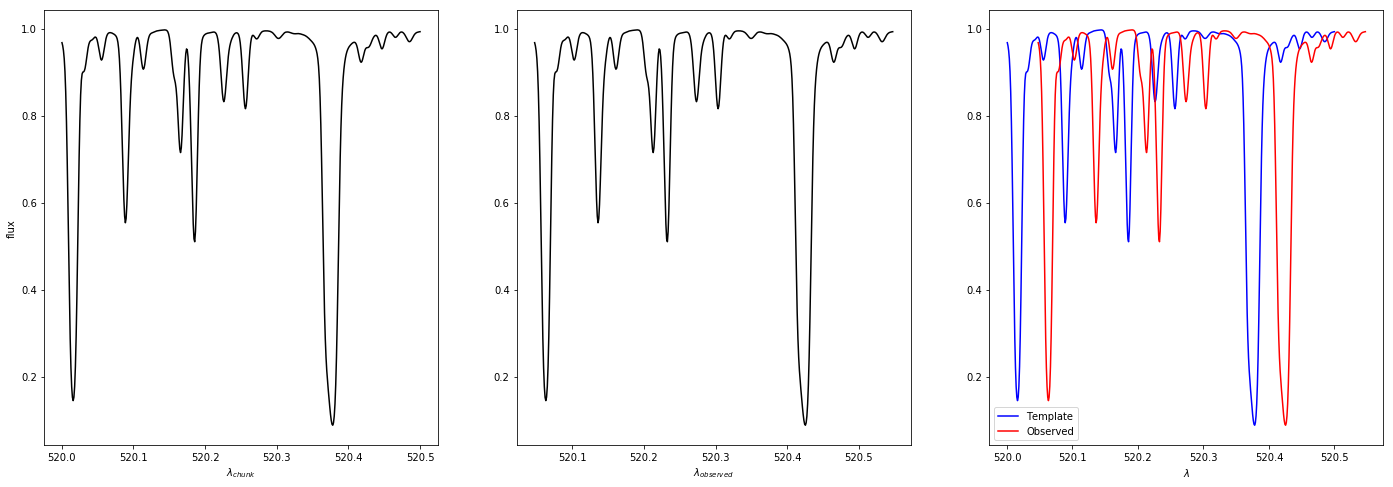

In [5]:
fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax1.plot(w_chunk,f,'k-')
ax2.plot(w_observed, f,'k-')
ax3.plot(w_chunk,f,'b-')
ax3.plot(w_observed, f,'r-')
ax3.legend(['Template','Observed'])
ax1.set_xlabel('$\lambda_{chunk}$')
ax2.set_xlabel('$\lambda_{observed}$')
ax3.set_xlabel('$\lambda$')
ax1.set_ylabel('flux')
plt.show()

## Simplest CCF

Now, the shifted spectrum is your "observed" spectrum. Our next task would be to try to get the RV of this observed spectrum with CCF using the "stellar template", which is the original spectrum before the shift (note: this stellar template has a wider wavelength span than your order of shifted spectrum, so we don't have to worry about edge effects). 

Note: Some people use a mask instead of a stellar template (Baranne et al. 1996) then fit a Gaussian to the CCF - it's mathematically equivalent with using a spectrum (with a Gaussian line profile) to perform the CCF and obtain the minima/maxima of the CCF (credit: David Hogg).

Our eventual goal is to obtain the CCF as a function of redshift $z$, and then find the minima of the CCF, which would be your reported $z$. **Important**: You have to fit the redsfhit $z$ instead of the RV! This is because **$z$ is what you are actually measuring, not the relative RV** between your stellar template and your observed template. To translate $z$ into RV, you need to perform the barycentric correction, which involves relativistic terms so a simple $z = RV/c$ does not work.

The first thing is to create an array of $z$ values. Think carefully about what min and max values should you give this array of $z$ when it comes to real observations.

In [52]:
#For z, at first I chose -(3E4)/c ~ (3E4)/c only consider about the BC shift
z_max=(3E4)/c
z_min=(-3E4)/c
print(z_max)
print(z_min)
z_list=np.linspace(z_min,z_max,200)
z_example= 9E-5
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)]
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]

0.000100069228559
-0.000100069228559


Next, for each $z$ value, you would need to shift your stellar template spectrum to this $z$, and then you want to interpolate your spectrum so that it is evaluated at the same array of wavelenghs as your observed spectrum in order to perform CCF (i.e., same abscissa). Write a function to perform this shift and interpolation.

Make sure to use cubic spline interpolation, not linear.

In fact, neither cubic spline nor linear interpolation conserves flux and therefore Doppler shift. At the sampling rate of our synthetic spectrum, cubic spline does a good enough job that we can ignore this. Very often, when you are working with spectrum with relatively low sampling, you want to up-sample your spectrum first before doing interpolation. Let's don't worry about it right now.

In [53]:
def spec_interpolation(z,w1,flux,w2):   #w1:template wavelength, w2:predicted wavelength
    w1_correction=w1*(1+z)
    f = interpolate.interp1d(w1_correction,flux,kind='cubic')
    #f = interpolate.interp1d(w1_correction,flux)
    flux_pred = f(w2)
    return flux_pred

Check your shift+interpolation function out by plotting a zoomed in chunk of spectrum before and after the operation.

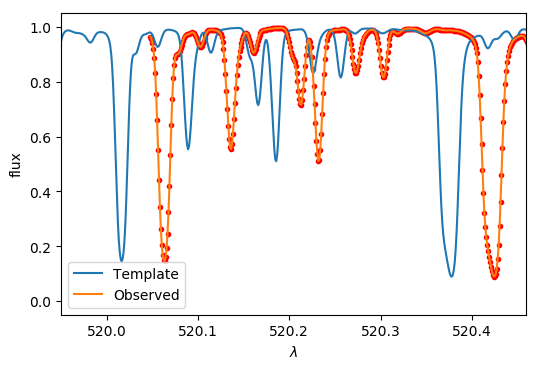

In [8]:
#Example#
z_example= 9E-5
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)]
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]
#print(w_template)
#print(w_emitted)
#exit()
flux_pred = spec_interpolation(z_example,w_template,f_template,w_observed)
plt.figure()
plt.plot(wavelength,flux)
plt.plot(w_observed,flux_pred)
plt.legend(['Template','Observed'])
plt.scatter(w_observed,flux_pred,color='red',marker='.')
plt.xlim(519.95,520.46)
plt.xlabel('$\lambda$')
plt.ylabel('flux')
plt.show()

Now, write a loop to evaluate the CCF at every $z$ value in your $z$ array.

**Important Caution**: Some people like to use the simpler version of CCF, which is $\sum{s*f}$, where $s$ and $f$ are the two functions you are performing CCF on. However, this is wrong in our context. The formal CCF is really $\sum{(s-f)^2}$, and when you have a constant $\sum{s^2}$ and $\sum{f^2}$, you can just use the cross term. However, this is not true in our case! When we are shifting the stellar template spectrum around within the wavelength window of the observed spectrum, on the edge, some portion will be shifted in and out. So your template spectrum $s$ actually changes every time you use a different $z$, so $\sum{s^2}$ is not constant! 

In [9]:
def ccf(z_list,w_template,f_template,w_observed,f_observed):
    ccf_list=[]
    for z in z_list:
        CCF = np.sum((spec_interpolation(z,w_template,f_template,w_observed)-f_observed)**2)
        ccf_list=np.append(ccf_list,[CCF],axis=0)
        #print(CCF)
    return ccf_list

#Raw CCF#
ccf_result=ccf(z_list,w_template,f_template,w_observed,f)
print(ccf_result)


[  4.62386272e+01   4.57238592e+01   4.52228071e+01   4.47382820e+01
   4.42722663e+01   4.38268400e+01   4.34032994e+01   4.30030973e+01
   4.26269770e+01   4.22758442e+01   4.19499661e+01   4.16498115e+01
   4.13752227e+01   4.11261986e+01   4.09020419e+01   4.07021354e+01
   4.05249447e+01   4.03687893e+01   4.02309601e+01   4.01086133e+01
   3.99976460e+01   3.98935877e+01   3.97910051e+01   3.96845582e+01
   3.95683328e+01   3.94369272e+01   3.92851647e+01   3.91091349e+01
   3.89056444e+01   3.86730950e+01   3.84108233e+01   3.81197969e+01
   3.78017028e+01   3.74595446e+01   3.70967547e+01   3.67177570e+01
   3.63271244e+01   3.59300936e+01   3.55318455e+01   3.51379464e+01
   3.47537333e+01   3.43846636e+01   3.40358261e+01   3.37122134e+01
   3.34183234e+01   3.31583674e+01   3.29359854e+01   3.27544024e+01
   3.26162131e+01   3.25234927e+01   3.24776451e+01   3.24794738e+01
   3.25290936e+01   3.26259618e+01   3.27688408e+01   3.29557950e+01
   3.31842470e+01   3.34509392e+01

Plot your CCF vs. z.

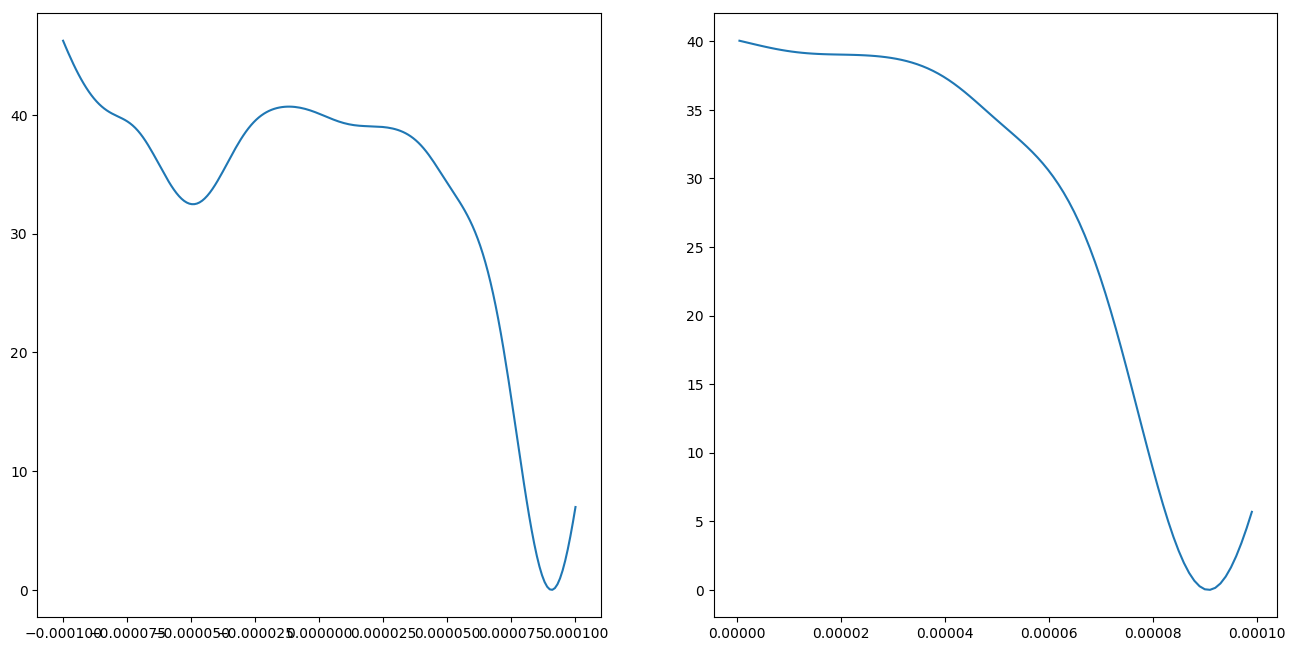

In [11]:
ccf_list = ccf_result
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.plot(z_list,ccf_list)
#ax1.xaxis.set_major_formatter(FormatStrFormatter('%.6f'))
ax2.plot(z_list[(z_list<10E-5) & (z_list>0)],ccf_result[(z_list<10E-5) & (z_list>0)])
ax1.set_xlabel('Z')
ax1.set_ylabel('CCF')
ax2.set_xlabel('Z')
plt.show()

Write a function to find the minimum of your CCF robustly.
Note: Do not fit a Gaussian to the CCF. When using a mask to derive CCF, one should fit a gaussian (i.e. average line profile). But since we are using a stellar template here, we should simply find the minimum of the CCF.

**Important Note:** It is important to think about how to make your function robust against noise. We are doing a noise-free case where the CCF is completely smooth, so it's relatively easy to find the true glocal minimum. However, if you CCF is more "bumpy" due to photon noise, and assume that you know the uncertainty on each of the CCF point, would you write your function differently? We don't have to do this here, but it's important to think about these realistic scenarios.

In [12]:
#LOOP to derive the best z#
for i in range(2):
    ccf_min = min(ccf_result)
    ccf_min_index = np.argmin(ccf_result,axis=0)
    z_expected = z_list[ccf_min_index]
    print(z_expected)
    z_list = np.linspace(z_list[ccf_min_index-1],z_list[ccf_min_index+1],200)
    ccf_result=ccf(z_list,w_template,f_template,w_observed,f)
    print('Loop %s has finished.'%(i+1))
    
    
ccf_min = min(ccf_result)
ccf_min_index = np.argmin(ccf_result,axis=0)
z_expected = z_list[ccf_min_index]

#result#
print ("z_espected=%s"%(z_expected))
#print ("z_correct=%s"%(z_correct))


9.1017740549e-05
Loop 1 has finished.
9.07296697413e-05
Loop 2 has finished.
z_espected=9.07327680961e-05


Now you have a measured z! Is it correct? How many m/s are you away from the correct answer, if any?

In [13]:
#After 3 loops... 
zerror=np.abs(z_expected-z_correct)
vrad_err=zerror*c
print("vrad_err=%s m/s"%(vrad_err))

vrad_err=0.000431312385263 m/s


# RV precision vs. spectral resolution and SNR

Great! You've measured the Doppler shift. If everything goes well, you should get almost exact the same answer as the input $z$. Of course we had a idealized case where there was no noise, and also the piece of spectrum we used was at basically infinite resolution and a very high sampling rate. In reality, we would never have such spectra from observations. 

In the following sections, we will explore how RV precision depends on things like spectral resolution and SNR. Let's start with spectral resolution first.

## Convolve spectrum with a PSF

Let's first convolve a chunk of stellar template or input synthetic spectrum with a PSF that corresponds to a spectral resolution of $R=120,000$, fairly common for modern PRV instrument.

We are going to assume that the spectral PSF (also known as the Intrumental Profile or IP, or the spectrograph response function or SRF) takes a symmetric Gaussian shape. This is again never true in reality, but for our purpose of figuring out RV precision vs. resolution, this will suffice.

Now before we start, there is an important assumption/simplication here, which is that we assume the PSF has a fixed width in pixel space across this chunk of spectrum you are dealing with. If we fix the resolution, this is certainly not true, because the width of the PSF would need to change when you go from a smaller $\lambda$ value to a larger $\lambda$ value since $\delta_\lambda = \lambda/R$. Convolving with a changing PSF would just cause unnecessary extra numerical calculation / computing time, so we will just convolve with a single PSF with a fixed width, calculated based on the median wavelength of your spectral chunk.

Now, here are the steps for convolving a spectrum down to any given resolution:
1. Figure out the dispersion scale of your spectrum:
$\delta_\lambda = \overset{\circ}{A}$ per pixel of your observed spectrum. This does not change a lot across the spectral chunk you choose (hopefully!), so you can use any $\lambda(i+1)-\lambda(i)$ or take the median.  

2. Assuming your resolution is $R$ at wavelength $\lambda$, figure out the resolution element in $\overset{\circ}{A}$:
$FWHM_\lambda = \lambda / R$ (unit = $\overset{\circ}{A}$), 
which is assuming your resolving power is set by the FWHM of the Gaussian PSF. 

3. Because the FWHM of a Gaussian = 2.3548$\sigma$:
$\sigma_\lambda = FWHM_\lambda/2.3548$ (unit = $\overset{\circ}{A}$)

4. Now, what's the width of your Gaussian in pixel space:
$\sigma_{pixel} = \sigma_\lambda / \delta_\lambda$ (unit = pixel), so that when your are constructing your Gaussian, you could just use a simple pixel grid, say, from -15 to 15 (you may need to make this wider; plot it out to make sure), as your x-axis.

5. If the sampling factor of your original spectrum is not very high, then I would recommend up-sample your spectrum first, then convolve, and then down-sample it back to the original wavelength scale. In our case, the synthetic spectrum has a pretty high sampling rate, so there is no need to do this (although the wavelength grid is not perfectly even, which would just mean that our resolution would change a bit, but that's ok). As up-sampling and down-sampling is not as easy as interpolation back and forth due to the need to conserve flux (and thus Doppler shift), let's not get into that for now. But if you are interested, you can check out this post on AstroBetter (note that the python package has changed quite a bit, but if you read the docs you'd figure out how to use it):
https://www.astrobetter.com/blog/2013/08/12/python-tip-re-sampling-spectra-with-pysynphot/

You can also just use the $\lambda$ array of your spectral chunk as the x-axis to create the PSF, of course, then you could just use $\sigma_\lambda$ instead of $\sigma_{pixel}$. This would just give you a lot of zeros in your PSF, which would be unnecessary. 

Now, please go head and write a function to do this, and convolve the spectrum down to $R=120,000$.

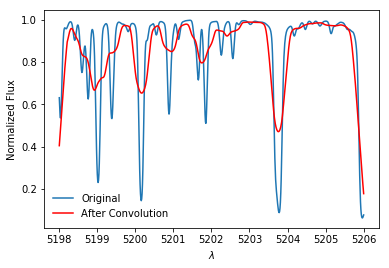

In [124]:
#####################################use PSF in the pixel space###################################################
pixel_range_size=20                              #set the pixel range size for the PSF
def psf_pixel(wavelength,resolution,delta_lambda):
    fwhm_lambda = wavelength / resolution
    sigma_lambda = fwhm_lambda / 2.3548
    sigma_pixel = sigma_lambda / delta_lambda
    #center = np.rint( (wavelength-np.min(w)) / delta_lambda )
    pixel_range = np.linspace(-pixel_range_size, pixel_range_size, 2 * pixel_range_size + 1)
    psf_raw=(1.0/(np.sqrt(2*np.pi)*sigma_pixel))*np.exp(-(pixel_range)**2/(2*sigma_pixel**2))
    return psf_raw/np.sum(psf_raw)

flux_total=[0 for x in range(0, len(w_template))]
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)] * 10    #in A
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]

#-----calculate the median dispersion scale delta_lambda-----#
delta_lambda_list = []
for i in range(len(w_template)-1):
    delta_lambda_list = np.append(delta_lambda_list,[w_template[i+1]-w_template[i]],axis=0)
mean,median,sigma=apstat.sigma_clipped_stats(delta_lambda_list)
delta_lambda = median

#pixel_template=np.rint( (w_template-np.min(w_template)) / delta_lambda )

##----------convolution part----------##
R=10000
for i in range(len(w_template)):
    this_psf = psf_pixel(w_template[i],R,delta_lambda)
    convolution=np.convolve(f_template[i],this_psf)
    #print(convolution)
    if i <  pixel_range_size:
        template=[0 for x in range(0, len(w_template))]
        for j in range(0, i+pixel_range_size+1):
            template[j]=convolution[j - (i-pixel_range_size)]
        #flux_total+=template
        flux_total=np.sum([flux_total,template], axis = 0)
        
    elif i >= pixel_range_size and i <=len(w_template)-pixel_range_size-1:
        template=[0 for x in range(0, len(w_template))]
        for j in range( i-pixel_range_size, i+pixel_range_size+1 ):
            template[j]= convolution[j - (i-pixel_range_size)]
        flux_total=np.sum([flux_total,template], axis = 0)
    
    elif i >= len(w_template) - pixel_range_size:
        template=[0 for x in range(0, len(w_template))]
        for j in range( i-pixel_range_size, len(w_template) ):
            template[j]= convolution[j - (i-pixel_range_size)]
        flux_total=np.sum([flux_total,template], axis = 0)
    #else :
    #    break


plt.figure()
plt.plot(w_template,f_template)
plt.plot(w_template,flux_total,color='red')
plt.legend(['Original','After Convolution'],fontsize=10,frameon=False,loc=3)
plt.xlabel('$\lambda$')
plt.ylabel('Normalized Flux')
plt.show()



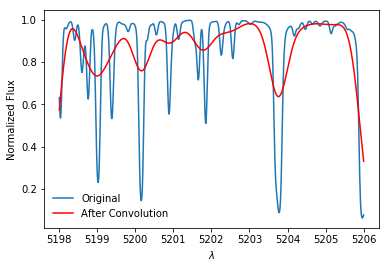

In [120]:
#######################################use PSF in the wavelength space###########################################
def psf(w,wavelength,resolution):
    fwhm_lambda = wavelength / resolution
    sigma_lambda = fwhm_lambda / 2.3548
    psf_raw = (1.0/(np.sqrt(2*np.pi)*sigma_lambda))*np.exp(-(w-wavelength)**2/(2*sigma_lambda**2))
    return psf_raw/np.sum(psf_raw)
    
flux_total=[0 for x in range(0, len(w_template))]
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)] * 10    #in A
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]

#-----calculate the median dispersion scale delta_lambda-----#
delta_lambda_list = []
for i in range(len(w_template)-1):
    delta_lambda_list = np.append(delta_lambda_list,[w_template[i+1]-w_template[i]],axis=0)
mean,median,sigma=apstat.sigma_clipped_stats(delta_lambda_list)
delta_lambda = median

R = 10000   
for i in range(len(w_template)):
    this_psf = psf(w_template,w_template[i],R)
    #this_psf = this_psf/np.sum(this_psf)
    flux_total += np.convolve(f_template[i],this_psf)
    
plt.figure()
plt.plot(w_template,f_template)
plt.plot(w_template, flux_total,'r-')
plt.legend(['Original','After Convolution'],fontsize=10,frameon=False,loc=3)
plt.xlabel('$\lambda$')
plt.ylabel('Normalized Flux')
plt.show()

Then plot the original spectrum vs. the broadened spectrum. 

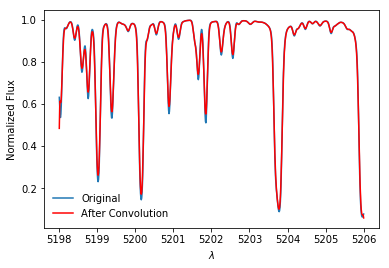

In [88]:
plt.figure()
plt.plot(w_template,f_template)
plt.plot(w_template, flux_total,'r-')
plt.legend(['Original','After Convolution'],fontsize=10,frameon=False,loc=3)
plt.xlabel('$\lambda$')
plt.ylabel('Normalized Flux')
plt.show()

Huh! They almost look identical! Did you see that coming? ;)
This is because the solar spectrum is dominated by rotation broadening, so the lines are already fully resolved at this high resolution of $R=120,000$. Explore a few different lower resolution values and see when you would start seeing an obvious broadening of the stellar spectrum (say, from $R=10,000$). At what resolution do the stellar lines begin to be fully resolved?

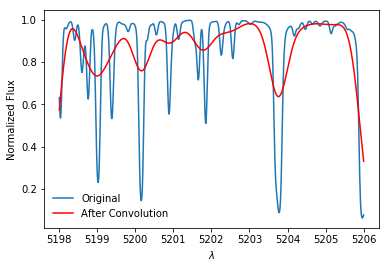

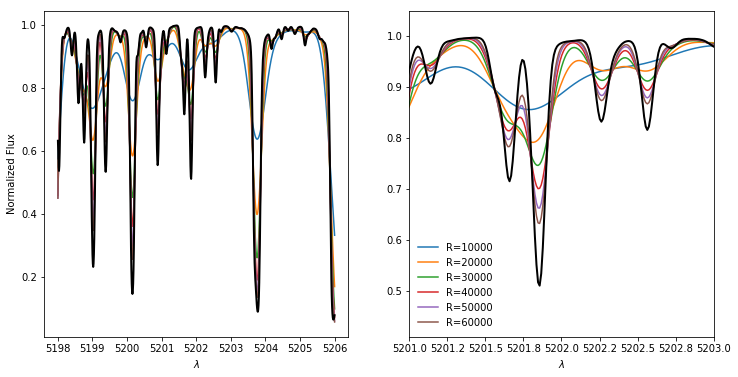

In [108]:
R = 10000
flux_total=[0 for x in range(0, len(w_template))]
for i in range(len(w_template)):
    this_psf = psf(w_template,w_template[i],R)
#    this_psf = this_psf/np.sum(this_psf)
    flux_total+=np.convolve(f_template[i],this_psf)

plt.figure()
plt.plot(w_template,f_template)
plt.plot(w_template, flux_total,'r-')
plt.legend(['Original','After Convolution'],fontsize=10,frameon=False,loc=3)
plt.xlabel('$\lambda$')
plt.ylabel('Normalized Flux')
plt.show()

R_list=np.linspace(10000,60000,6)
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
for i in range(len(R_list)):
    flux_total=[0 for x in range(0, len(w_template))]
    for j in range(len(w_template)):
        this_psf = psf(w_template,w_template[j],R_list[i])
        #this_psf = this_psf/np.sum(this_psf)
        flux_total+=np.convolve(f_template[j],this_psf)
    ax1.plot(w_template, flux_total)
    ax2.plot(w_template, flux_total)
ax2.legend(['R=%s'%(int(R_list[0])),'R=%s'%(int(R_list[1])),'R=%s'%(int(R_list[2])),\
            'R=%s'%(int(R_list[3])),'R=%s'%(int(R_list[4])),'R=%s'%(int(R_list[5]))],frameon=False)
ax1.plot(w_template, f_template,'k-',linewidth=2)
ax2.plot(w_template, f_template,'k-',linewidth=2)
ax1.set_xlabel('$\lambda$')
ax2.set_xlabel('$\lambda$')
ax2.set_xlim([5201,5203])
ax2.set_ylim([0.41,1.05])
ax1.set_ylabel('Normalized Flux')
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()


## Add Poisson (photon) noise to the spectrum

Now in order to give some "uncertainty" to our measured Doppler shift, we need to add in photon noise. These will follow a Poisson distribution for each data point. Let's do the following to create a shifted, noise-added, spectrograph-broadened spectrum:

(It's important to follow these orders! Do you know why?)

(1). Doppler shift your spectral chunk using an arbitrary $z$ value (maybe recycle the one above?).

In [ ]:
w_shift=w_template*(1+z_correct)

(2). Write a function to add Poison noise to each data point according to a given signal-to-noise ratio (SNR). Test your function with a SNR=200. Plot the noisy spectrum on top of the original, compute the RMS of the residuals of the difference between the two to make sure you get it right.

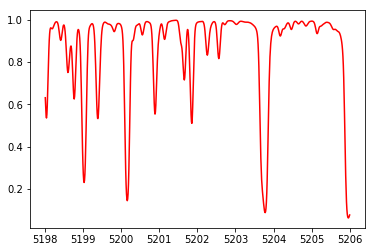

In [109]:
SNR=200
poisson_error=[]
for i in range(len(f_template)):
    poisson = np.random.poisson(lam=f_template[i], size=1)
    poisson_error=np.append(poisson_error,poisson,axis=0)
    #print(f_template[i]/w_template[i])

#print(poisson_error)    
plt.figure()
#plt.errorbar(w_template,f_template,yerr=poisson_error,alpha=0.3)
plt.errorbar(w_template,f_template,color='red')
plt.show()

(3). Use your broadening function above to broaden your spectrum into $R=120,000$.

(4). Measure the Doppler shift of this shifted, broadened spectrum. What should you use as your stellar template? Use your original unshifted noiseless spectrum, but broaden it according to your resolution --- that would be your stellar template. Here we have assumed that we know the PSF of our spectrograph perfectly well, which is not uncommon for the state-of-the-art RV instruments.

How far are you this time from the correct answer in m/s?

(5). Repeat from step #2 but use a different random number seed for the Poisson noise to create another "observed spectrum" and measure its Doppler shift. Repeat this many times to get a suite of $z$ values that your measure. What's the scatter in your $z$ measurements in m/s? That's your precision for a SNR=200, $R=120,000$ spectrum with your chosen wavelength coverage!

This is of course a very rustic way of finding out the RV error and it's relatively computational intensive. There are smarter and faster ways to do it. Feel free to try if you have other ideas!

(6). Now, repeat above, but change the resolution to $R=50,000$. Did you get a bigger error or a smaller error?

## Finally, RV precision vs. Resolution

(7). Repeat again for a suite of resolution values, say 8 different ones, ranging from 20,000 to 200,000. Plot $\sigma_{RV}$ as a function of resolution.

# Then, RV precision vs. SNR

Now you have all the machinery you need to explore RV precision vs. SNR as well. Fix the resolution to whatever you like, and repeat the $\sigma_{RV}$ estimates for different SNR and plot the relation of RV precision vs. SNR.